In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.insert(0, '..')

In [3]:

import glob
import math

import seaborn
import pandas
from matplotlib import pyplot as plt

from src.experiments.analyze import enrich_results, plot_size_improvement, name_strategies


In [4]:
def read_parquet(pattern, **kwargs):
    frames = []
    for file in glob.glob(pattern):
        part = pandas.read_parquet(file, **kwargs)
        frames.append(part)

    df = pandas.concat(frames)
    return df
    

In [16]:
#ref = read_parquet('../output/results/trees_min_samples_leaf_2/*sklearn*')
#ref['min_samples_leaf'] = 1
#ref['trees'] = 100
#ref = ref[ref.split <5 ]

hyper = read_parquet('../output/results/depth_limiters3/*.part')
#hyper = read_parquet('../output/results/max_depth/*trees*')
hyper['trees'] = hyper.n_estimators
#data = hyper
data = pandas.concat([hyper], ignore_index=True)
data = enrich_results(data, leaf_node_bytes_default=4)
#data['total_size_kb'] = data.total_size / 1000
data['leaf_size_percent'] = 100.0 * (data['leaf_size'] / data['total_size'])
data['unique_leaves_percent'] = 100.0 * (data['test_uniqueleaves'] / data['test_leaves'])
data = data[~data.dataset.isin(['1510'])]

for col in ['min_impurity_decrease', 'min_samples_split', 'max_leaf_nodes', 'max_depth', 'min_samples_leaf']:
    has_values = data[col].notna()
    data.loc[has_values, 'depth_limiter'] = col
    data.loc[has_values, 'depth_limiter_value'] = data.loc[has_values, col]

data.head(5)

,leaves_per_class,leaf_bits,split,test_nodes,test_leaves,test_leafsize,test_uniqueleaves,test_roc_auc,train_roc_auc,dataset,...,max_depth,min_samples_leaf,trees,leaf_size,decision_size,total_size,leaf_size_percent,unique_leaves_percent,depth_limiter,depth_limiter_value
id,,,,,,,,,,,,,,,,,,,,,
e9a0ce8b-0acc-439c-b672-b609cf4fe4f2,NaN,NaN,0,916,463,4.0,4,99.888355,1.0,458,...,NaN,NaN,10,64.0,3624,3688.0,1.735358,0.863931,max_leaf_nodes,73.0
f29face2-aebc-40c0-81d4-ea89ba25cde0,1.0,NaN,0,916,463,4.0,4,99.888355,1.0,458,...,NaN,NaN,10,64.0,3624,3688.0,1.735358,0.863931,max_leaf_nodes,73.0
9322aabe-ca06-404b-a20c-35d3be52f470,2.0,NaN,0,916,463,4.0,4,99.888355,1.0,458,...,NaN,NaN,10,64.0,3624,3688.0,1.735358,0.863931,max_leaf_nodes,73.0
6fb127ba-0e65-437c-a956-82211ede324d,4.0,NaN,0,916,463,4.0,4,99.888355,1.0,458,...,NaN,NaN,10,64.0,3624,3688.0,1.735358,0.863931,max_leaf_nodes,73.0
c0f66ddd-befe-4ca5-a770-7e18e362cfb4,8.0,NaN,0,916,463,4.0,4,99.888355,1.0,458,...,NaN,NaN,10,64.0,3624,3688.0,1.735358,0.863931,max_leaf_nodes,73.0


In [17]:
data.depth_limiter.value_counts()

depth_limiter
max_leaf_nodes           107100
min_impurity_decrease    107100
max_depth                 89250
min_samples_split         71400
min_samples_leaf          71400
Name: count, dtype: int64

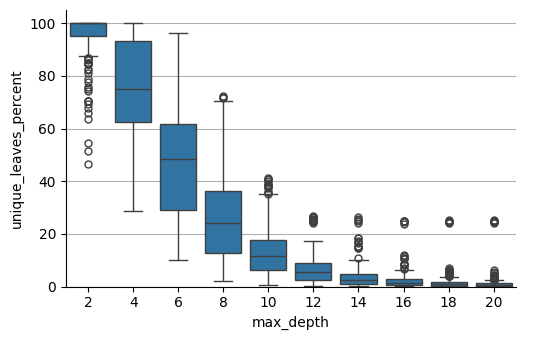

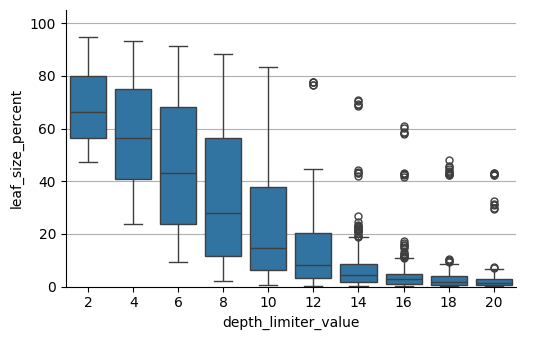

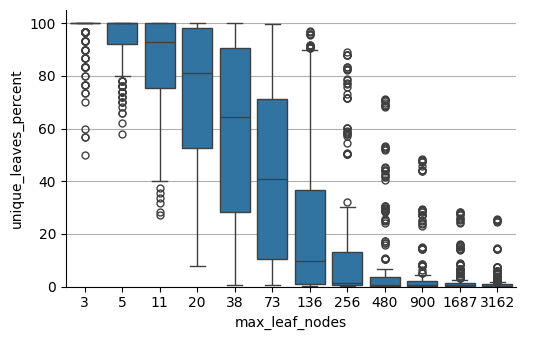

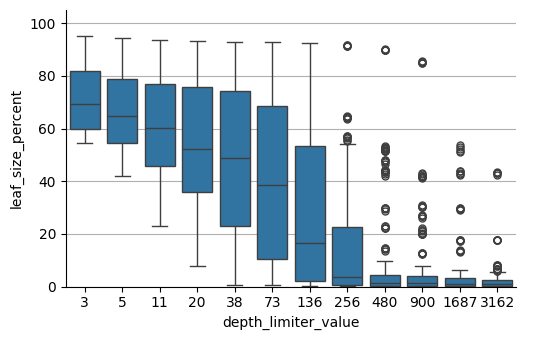

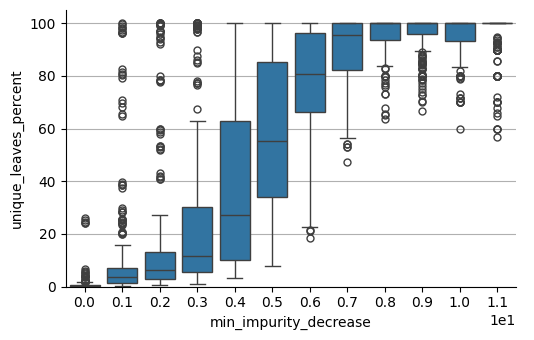

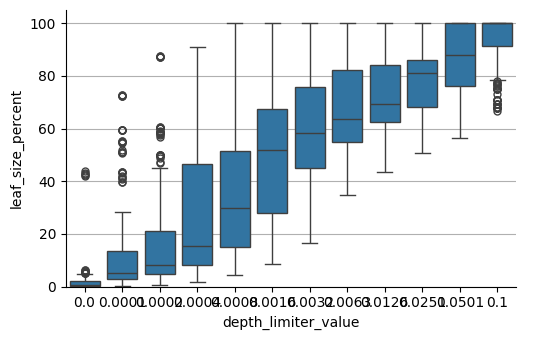

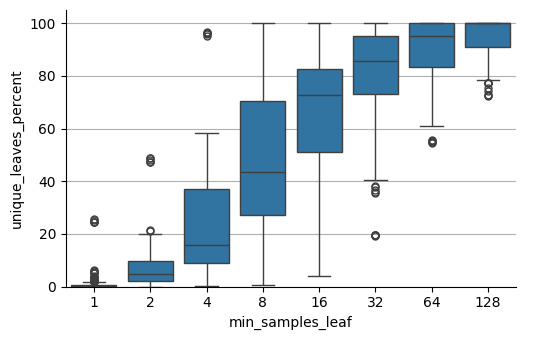

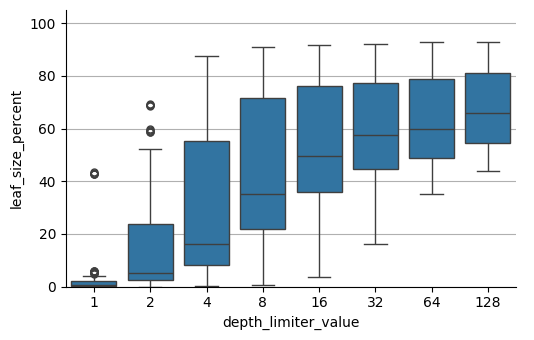

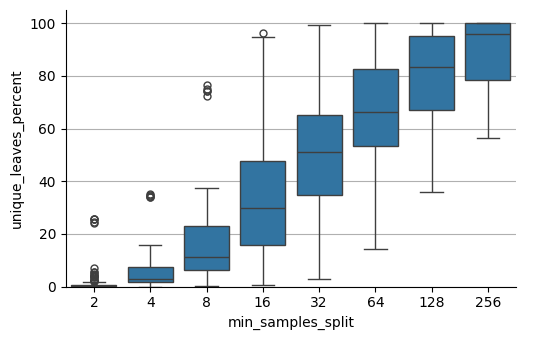

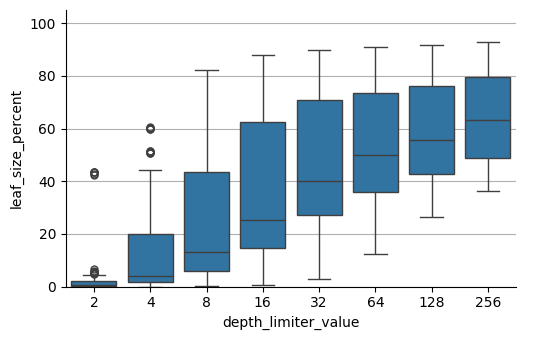

In [34]:
depth_limit = 'depth_limiter_value'
#depth_limit = 'max_depth'


def add_grid(g, **kwargs):
    for i, ax in enumerate(g.axes.flatten()):
        ax.grid(**kwargs)


sel = data.copy()
sel = name_strategies(sel)
sel = sel[(sel.strategy == 'original')]

#fig, axs = plt.subplots(ncols=2)
height = 3.5
aspect = 1.5
import matplotlib.ticker

for strategy, df in sel.groupby('depth_limiter'):

    #print(df.head())
    if strategy != 'min_impurity_decrease':
        df[depth_limit] = df[depth_limit].astype(int)

    # Leaf uniqueness
    g = seaborn.catplot(data=df,
                    x=depth_limit,
                    kind='box',
                    y='unique_leaves_percent',
                    #col='depth_limiter',
                    height=height, aspect=aspect)
    ax = g.axes[0][0]
    if strategy == 'min_impurity_decrease':
        ax.xaxis.set_major_formatter(matplotlib.ticker.ScalarFormatter())
        ax.axes.ticklabel_format(axis='x', scilimits=(0,0), style='sci')
        
    g.set(ylim=(0, 105))
    add_grid(g, axis='y')
    g.set_xlabels(strategy)
    g.figure.tight_layout()
    g.figure.savefig(f'leaf-uniqueness-{strategy}.png')


    # Leaf size proportion
    g = seaborn.catplot(data=df,
                    x=depth_limit,
                    kind='box',
                    y='leaf_size_percent', 
                    height=height, aspect=aspect,)
    g.set(ylim=(0, 105))
    add_grid(g, axis='y')
    if strategy == 'min_impurity_decrease':
        ax.xaxis.set_major_formatter(matplotlib.ticker.ScalarFormatter())
        ax.axes.ticklabel_format(axis='x', scilimits=(0,0), style='sci')
    g.figure.tight_layout()
    g.figure.savefig(f'leaf-proportion-{strategy}.png')

